In [1]:
from torchvision import datasets, transforms
import torch
from matplotlib import pyplot
from typing import Union, List
import doctest

# Vanilla Neural Net From Scratch

Creates a MLP using basic matrix manipulation only, in PyTorch. It does not use e.g. `nn.Linear`, `nn.ReLU` or `nn.Module`, and instead users lower level tensor operations (e.g. `matmul`).

Most of the underlying equations are taken from the [Stanford Multi Layered Neural Networks tutorial](http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks).

## MNIST Data

This model uses the [MNIST](https://pytorch.org/vision/stable/datasets.html#mnist) dataset of 32x32 grayscale images of hand-written digets. There are 60,000 training images and 10,000 test images (example image shown below).

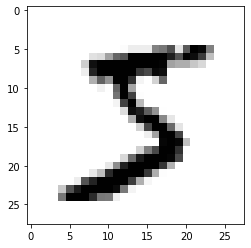

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
train_dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST("./data", train=False, download=True, transform=transform)
pyplot.imshow(train_dataset[0][0].squeeze(), cmap='gray_r') # Squeeze to remove the color dimension (always 1 as grayscale)

We're not using `DataLoader` for the from-scratch work, so instead we'll just create on giant tensor for all the images and another for all the values. Datasets are just a list of x,y tuples, so this is done as follows:

In [5]:
images_list = [i[0].flatten() for i in train_dataset]
values_list = [i[1] for i in train_dataset]
images = torch.stack(images_list)
values_horizontal = torch.tensor(values_list)
values = torch.unsqueeze(values_horizontal, 1)
values
images.shape, values.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [ ]:
## SGD

In [ ]:
layer_1 = 784, 64
layer_2 = 64, 10

def epoch(w1,w2,b1,b2):
    # Forward pass
    
    # Layer 1
    
    

In [6]:
batch_size = 16

def create_batches(data: torch.dataset) -> List[torch.tensor]:
    batches = []
        
    for (index, item) in enumerate(data):
        batch_index = index // batch_size
        batches[batch_index].append(item)
        


images = [i[0].flatten() for i in train_dataset]
values = [i[1] for i in train_dataset]
images[0].shape, values[0]

AttributeError: module 'torch' has no attribute 'dataset'

In [ ]:
tensor(images)

### Activation Function (Sigmoid)

$\displaystyle
f(z) = \frac{1}{1+\exp(-z)}$

In [7]:
def sigmoid(input: tensor) -> tensor:
    """
    Returns a tensor with the sigmoid of the elements of input
    
    Equivalent to torch.nn.functional.sigmoid
    
    >>> sigmoid(tensor([1.,2]))
    tensor([0.7311, 0.8808])
    
    Parameters
    ----------
    input: input tensor
    """
    denominator = 1 + exp(-input)
    return 1 / denominator

NameError: name 'tensor' is not defined

## Neuron Output

<center><img src="http://ufldl.stanford.edu/tutorial/images/SingleNeuron.png" width="400"/></center>

$\displaystyle
h_{W,b}(x) = f(W^Tx), x \in \mathbb{R}^{1 \times n}, W \in \mathbb{R}^{m \times n}$

In the above example this is:

$\displaystyle
h_{W,b}(x) = f(\sum^3_{i=1} W_ix_i + b) = f(z)$ where $x \in \mathbb{R}^{1 \times 3}, W \in \mathbb{R}^{1 \times 3}$

The weighted sum inputs ($z$) are calculated using the following function, and then sigmoid is applied to the result to get the activations $f(x)$:

In [ ]:
def weighted_sum_inputs(inputs: tensor, weights: tensor, bias: float) -> tensor:
    """
    Returns the weighted sum of inputs, including the bias term.
    
    >>> # Single item, 2 inputs, 1 ouput
    >>> i = tensor([1., 1]) # m = 2, n = 1
    >>> w = tensor([1., 1]) # m = 2, n = 1
    >>> weighted_sum_inputs(i,w,1)
    tensor(3.)
    
    >>> # Single item, 2 inputs, 3 ouputs
    >>> i = tensor([1., 1]) # m = 2, n = 1
    >>> w = tensor([[1., 2, 3], [1, 1, 1]]) # m = 2, n = 3
    >>> weighted_sum_inputs(i,w,1)
    tensor([3., 4., 5.])
    
    >>> # Batch 3 items, 2 inputs, 1 ouput
    >>> i = tensor([[1., 1, 1], [1, 1, 1]]) # m = 2, n = 3
    >>> w = tensor([[1.], [1.]]) # m = 2, n = 1
    >>> weighted_sum_inputs(i,w,1) # 3x1
    tensor([[3., 3., 3.]])
    
    Parameters
    ----------
    inputs: 
        Row matrix for single item (1xm) with m = number of inputs. Matrix
        (nxm) for a batch with n = batch size.
    weights: 
        Row matrix for single output (1xm) with m = number of inputs. Matrix
        (nxm) for multiple outputs (e.g. on a hidden layer here) with
        n = number of outputs.
    bias: bias term
    
    Returns
    -------
    Matrix (nxm) of outputs where n = batch size and m = number of output
        neurons.
    """
    weights_transposed = transpose(weights, 0, -1)
    return matmul(weights_transposed, inputs) + bias

## Neural Network Model

<center><img src="http://ufldl.stanford.edu/tutorial/images/Network331.png" width="400"/></center>

### Forward Propogation

The model is defined as follows:

$
a^l = \text{activation for layer } l
\\
W^{(l)} = \text{weights for layer } l
\\
z^{(2)} = W^{(1)}x + b^{(1)}
\\
a^{(2)} = f(z^{(2)})
\\
z^{(3)} = W^{(2)} a^{(2)} + b^{(2)}
\\
h_{W,b}(x) = a^{(3)} = f(z^{(3)})$

Note this will be implimented as part of the overall MLP rather than directly here, as we will need the component parts for backpropogation as well.

### Loss Function

For a single training example, our loss is half squared-error (half to make the derivative easier):

$
\displaystyle
J(W, b, x, y) = \frac{1}{2}(h_{W,B}(x)-y)^2$

In [ ]:
def half_squared_error(activations: tensor, target_values: tensor) -> tensor:
    """
    Returns the half squared error, calculated elementwise
    
    >>> half_squared_error(tensor([1.,1]), tensor([1., 3]))
    tensor([0., 2.])
    
    Parameters
    ----------
    activations:
        Matrix (nxm) of activations where n = batch size and m = number of 
        activations.
    target_values:
        Matrix (nxm) of target values (y-values) where n = batch size and
        m = number of target values per single batch item.
    """
    return 0.5 * ((activations - target_values) ** 2)

For a batch of size $m$, we can take the average cost (plus weight decay) as:

$\begin{align}
C = J(W,b)
&= \left[ \frac{1}{m} \sum_{i=1}^m J(W,b;x^{(i)},y^{(i)}) \right]
                       + \frac{\lambda}{2} \sum_{l=1}^{n_l-1} \; \sum_{i=1}^{s_l} \; \sum_{j=1}^{s_{l+1}} \left( W^{(l)}_{ji} \right)^2
 \\
&= \left[ \frac{1}{m} \sum_{i=1}^m \left( \frac{1}{2} \left\| h_{W,b}(x^{(i)}) - y^{(i)} \right\|^2 \right) \right]
                       + \frac{\lambda}{2} \sum_{l=1}^{n_l-1} \; \sum_{i=1}^{s_l} \; \sum_{j=1}^{s_{l+1}} \left( W^{(l)}_{ji} \right)^2
\end{align}$

Weight decay is just the sum-of-squares of all weight values (in all layers and all dimensions), multiplied by a weight decay parameter $(\lambda)$. It decreases the magnitude of the weights, to prevent overfitting.

In [ ]:
def batch_loss(predictions: tensor, target_values: tensor, weights: List[tensor], weight_decay_parameter: float) -> float:
    """
    Batch loss
    
    Returns the half mean squared error across a batch, plus a 
    weight decay term.
    
    >>> # Single batch item, single activation per item
    >>> predictions = tensor([1.])
    >>> target_values = tensor([3.])
    >>> weights = [tensor([1.])]
    >>> weight_decay_parameter = 0.
    >>> batch_loss(predictions,target_values,weights,weight_decay_parameter)
    2.0
    
    >>> # 3 batch items, single activation per item
    >>> predictions = tensor([[1.],[2],[3]])
    >>> target_values = tensor([[2.],[3],[4]])
    >>> weights = [tensor([1])]
    >>> weight_decay_parameter = 0.
    >>> batch_loss(predictions,target_values,weights,weight_decay_parameter)
    0.5
    
    Parameters
    ----------
    predictions:
        Matrix (nxm) of activations where n = batch size and m = number of 
        activations (i.e. a column vector for a batch with single outputs
        per item).
    target_values:
        Matrix (nxm) of target values (y-values) where n = batch size and
        m = number of target values per single batch item.
    weights: 
        List of all weight tensors (for each layer) in the model. These
        can be in any order as they are simply summed as part of the
        weight decay calculations.
    weight_decay_parameter: weight decay parameter (lambda)
    
    """
    # Calculate the mean half squared error
    half_squared_errors = half_squared_error(predictions, target_values)
    count_predictions = numel(predictions)
    mean_half_squared_error = torch.sum(half_squared_errors) / count_predictions
    
    # Calculate the weight decay
    sum_weights = sum([torch.sum(w ** 2) for w in weights])
    weight_decay = sum_weights * weight_decay_parameter / 2
    
    loss = mean_half_squared_error + weight_decay
    return loss.item() # Cast single-element tensor as float

### Backpropogation

#### Step function

$
\begin{align}
W_{ij}^{(l)} &= W_{ij}^{(l)} - \alpha \frac{\partial}{\partial W_{ij}^{(l)}} J(W,b) \\
b_{i}^{(l)} &= b_{i}^{(l)} - \alpha \frac{\partial}{\partial b_{i}^{(l)}} J(W,b)
\end{align}
$

In [ ]:
def step(weight_or_bias: Union[tensor, float], learning_rate: float, gradient: Union[tensor, float]) -> Union[tensor, float]:
    """
    Returns an updated weight or bias tensor, stepped by the learning rate 
    multipled by the gradient vector.
    
    >>> # Step a bias
    >>> step(1., 0.01, 1.)
    0.99
    
    >>> # Step a weight
    >>> weight = tensor([[1.,2],[3,4]])
    >>> learning_rate = 0.01
    >>> gradient = tensor([[2.,2],[2,2]])
    >>> step(weight, learning_rate, gradient)
    tensor([[0.9800, 1.9800],
            [2.9800, 3.9800]])
    
    Parameters
    ----------
    weight_or_bias:
        Weight tensor of size mxn where m = number of inputs and 
        n = number of outputs, or a bias float
    learning_rate:
        Learning rate (e.g. 0.01)
    gradient: Gradient vector if stepping weights, of size mxn where
    m = number of inputs and n = number of outputs, or a partial
    derivative (float) if stepping the bias
    """
    
    return weight_or_bias - (learning_rate * gradient)

#### Gradients

The derivative for the overall cost function is:

$
\begin{align}
\frac{\partial}{\partial W_{ij}^{(l)}} J(W,b) &=
\left[ \frac{1}{m} \sum_{i=1}^m \frac{\partial}{\partial W_{ij}^{(l)}} J(W,b; x^{(i)}, y^{(i)}) \right] + \lambda W_{ij}^{(l)} \\
\frac{\partial}{\partial b_{i}^{(l)}} J(W,b) &=
\frac{1}{m}\sum_{i=1}^m \frac{\partial}{\partial b_{i}^{(l)}} J(W,b; x^{(i)}, y^{(i)})
\end{align}
$

To caclulate the partial derivatives, we first calculate the error term $\delta^{(l)}_i$ for each node $i$ in layer $l$.

For the output unit in the output layer, this is:

$\begin{align}
\delta^{(n_l)}_i
= \frac{\partial}{\partial z^{(n_l)}_i} \;\;
\frac{1}{2} \left\|y - h_{W,b}(x)\right\|^2 = - (y_i - a^{(n_l)}_i) \cdot f'(z^{(n_l)}_i)
\end{align}
$

This gives error terms for the output layer as ($\textstyle \bullet$ denotes element-wise product):

$\begin{align} \delta^{(n_l)} = - (y - a^{(n_l)}) \bullet f'(z^{(n_l)}) \end{align}$

Note also that the derivative of sigmoid is:

$f'(z) = f(z) (1-f(z))$

In [ ]:
def error_terms_output_layer(predictions: tensor, target_values: tensor, predictions_before_activation: tensor) -> tensor:
    """
    Returns the error terms for the output layer
    
    >>> error_terms_output_layer(tensor([1.]), tensor([3.]), tensor([2.]))
    tensor([4.])
    
    Parameters
    ----------
    predictions: predictions
    target_values: target values (e.g. y-values)
    predictions_before_activation: weights elementwise-multiplied by inputs plus bias
    """
    activation_derivative = predictions_before_activation * (1 - predictions_before_activation)
    
    error_derivative = predictions - target_values
    
    return activation_derivative * error_derivative

In [ ]:
error_terms_output_layer(tensor([[1.],[2]]), tensor([[3.],[4]]), tensor([[2.],[2]]))

The error term for layer $l$ is calculated as follows:

$\delta^{(l)}_i = \left( \sum_{j=1}^{s_{l+1}} W^{(l)}_{ji} \delta^{(l+1)}_j \right) f'(z^{(l)}_i)$

$\begin{align} \delta^{(l)} = \left((W^{(l)})^T \delta^{(l+1)}\right) \bullet f'(z^{(l)}) \end{align}$

In [ ]:
def error_terms_hidden_layer(layer_weights: tensor, error_terms_next_layer: tensor, predictions_before_activation: tensor) -> tensor:
    """
    Returns the error terms for a hidden layer
    
    >>> error_terms_hidden_layer(tensor([[1.,1],[1,1]]), tensor([1.,1]), tensor([1.,1]))
    tensor([0., 0.])
    
    Parameters
    ----------
    layer_weights: Weights used to caclulate this layers activations
    error_terms_next_layer: Error terms from the next layer (e.g. from error_terms_output_layer if we are on layer l-1)
    weighted_sum_inputs: weights elementwise-multiplied by inputs plus bias
    """
    activation_derivative = predictions_before_activation * (1 - predictions_before_activation)
    
    layer_weights_transposed = transpose(layer_weights, 0, -1)
    error_derivative = matmul(layer_weights_transposed, error_terms_next_layer)
    
    return activation_derivative * error_derivative

Finally we can therefore comput the desired gradients:

$
\begin{align}
\nabla_{W^{(l)}} J(W,b;x,y) &= \delta^{(l+1)} (a^{(l)})^T, \\
\nabla_{b^{(l)}} J(W,b;x,y) &= \delta^{(l+1)}.
\end{align}
$

In [ ]:
def weight_gradient(error_terms_next_layer: tensor, layer_activations: tensor) -> tensor:
    """
    Returns the gradient of the weights for a specific layer
    """
    layer_activations_transposed = transpose(layer_activations, 0, -1)
    return matmul(error_terms_next_layer, layer_activations_transposed)

## Gradient Descent

Finally we create the full gradient descent algorithm:

In [ ]:
def gradient_descent(x_batch: tensor, y_batch: tensor, epochs: int):
    # Initialise random weight and bias values
    weights_1 = rand(3,3)
    weights_2 = rand(3)
    bias_1 = 0.
    bias_2 = 0.
    
    for epoch in range(1):
        
        # Forward pass
        z2 = weighted_sum_inputs(x_batch, weights_1, bias_1)
        print(x_batch)
        print(transpose(weights_1,0,-1))
        print(bias_1)
        print(z2)
        
        a2 = sigmoid(z2)
        z3 = weighted_sum_inputs(z2, weights_2, bias_2)
        predictions = sigmoid(z3)

        # Loss
        loss = batch_loss(predictions, y_batch, [weights_1, weights_2], 0.01)
        print("Epoch", epoch, " loss ", loss)

        # Backpropogation
        error_terms_layer_3 = error_terms_output_layer(predictions, y_batch, z3)
        weight_2_gradient = weight_gradient(error_terms_layer_3, a2)
        
        # Step
        weights_2 = step(weights_2, 0.01, weight_2_gradient)
        
    

In [ ]:
gradient_descent(train_X, train_Y, 5)



doctest.testmod(verbose=False)